In [21]:
import polars as pl
import numpy as np

# sale_item_id, sale_order_id, product_id, quantity, price, amount
sale_items = pl.scan_parquet("testdb/sale_items.parquet")

# sale_order_id, order_date, customer_id, shop_id, freight
sale_orders = pl.scan_parquet("testdb/sale_orders.parquet")

# purchase_item_id, purchase_order_id, product_id, quantity, price, amount
purchase_items = pl.scan_parquet("testdb/purchase_items.parquet")

# purchase_order_id, order_date, supplier_id, shop_id, freight
purchase_orders = pl.scan_parquet("testdb/purchase_orders.parquet")

# customer_id, customer_name, gender
customers = pl.scan_parquet("testdb/customers.parquet").rename({"name": "customer_name"})

# product_id, product_name, color
products = pl.scan_parquet("testdb/products.parquet").rename({"name": "product_name"})

# supplier_id, supplier_name
suppliers = pl.scan_parquet("testdb/suppliers.parquet").rename({"name": "supplier_name"})

# tag_id, tag_name
tags = pl.scan_parquet("testdb/tags.parquet")

# customer_id, tag_id
customer_tags = pl.scan_parquet("testdb/customer_tags.parquet")


In [22]:
products.collect()

product_id,product_name,color
i32,str,str
0,"""prd_NuK""","""blue"""
1,"""prd_Onh68I""","""dark"""
2,"""prd_1NrS0QN""","""blue"""
3,"""prd_gO5Irz5""","""blue"""
4,"""prd_1ySJEU7c""","""light"""
…,…,…
9995,"""prd_72d40""","""red"""
9996,"""prd_9D4oR8C1""","""pink"""
9997,"""prd_SWetG3""","""yellow"""


In [29]:

# join sale_items with sale_orders, customers, products, tags

wt1 = ((sale_items.join(sale_orders, left_on="sale_order_id", right_on="sale_order_id", how="left")
       .join(products, on ="product_id", how="left")
       .join(customers, on ="customer_id", how="left")
       .join(customer_tags, on ="customer_id", how="left")
       .join(tags, on ="tag_id", how="left")
       ) 
       .filter( pl.col("product_name") == "prd_i6Sgm" ) 
       .group_by( pl.col("product_name"), pl.col("order_date").dt.month() )
       .agg( pl.sum("amount"), pl.count("sale_item_id").alias("cnt") ))

# wt1.show_graph( optimized = True )
wt1.collect()  # 27s


product_name,order_date,amount,cnt
str,i8,f64,u32
"""prd_i6Sgm""",8,583300.0,5139
"""prd_i6Sgm""",10,636766.0,5627
"""prd_i6Sgm""",6,587024.0,5121
"""prd_i6Sgm""",11,586530.0,5134
"""prd_i6Sgm""",7,683240.0,5864
…,…,…,…
"""prd_i6Sgm""",2,576308.0,4940
"""prd_i6Sgm""",3,675222.0,5910
"""prd_i6Sgm""",9,636500.0,5492


In [30]:
wt2 = ((sale_items.join(sale_orders, left_on="sale_order_id", right_on="sale_order_id", how="left")
       .join(products, on ="product_id", how="left")
       ) 
       .filter( pl.col("product_name") == "prd_i6Sgm" ) 
       .group_by( pl.col("product_name"), pl.col("order_date").dt.month() )
       .agg( pl.sum("amount"), pl.count("sale_item_id").alias("cnt") ))

# wt1.show_graph( optimized = True )
wt2.collect()  # 1.9s

product_name,order_date,amount,cnt
str,i8,f64,u32
"""prd_i6Sgm""",10,79458.0,699
"""prd_i6Sgm""",5,81244.0,694
"""prd_i6Sgm""",12,76076.0,673
"""prd_i6Sgm""",3,83638.0,734
"""prd_i6Sgm""",1,79306.0,686
…,…,…,…
"""prd_i6Sgm""",11,73416.0,649
"""prd_i6Sgm""",7,83182.0,718
"""prd_i6Sgm""",6,73416.0,638


对比 wt2 和 wt1 的执行，wt1 花了 27s，wt2 花了 1.9s，wt2 是 wt1 的 14 倍。

wt1 的执行计划中，有 5个 join 操作，而 wt2 只有 2 join 操作，但实际执行上，另外3个表，并没有参与查询，理论上是可以进行优化的。
这也说明了 polars 在优化上还存在很大的空间。比如，对查询计划进行减枝。

In [31]:
wt2 = (sale_items.join(sale_orders, left_on="sale_order_id", right_on="sale_order_id", how="left")
       .join(products, on ="product_id", how="left")
       ) 
wt2.collect()

sale_item_id,sale_order_id,product_id,quantity,price,amount,order_date,customer_id,shop_id,freight,product_name,color
i64,i32,i32,i32,f64,f64,date,i32,i32,f64,str,str
176566138,17656613,25,2,35.0,70.0,2022-04-11,333218,39,70.0,"""prd_R428ZQ2""","""blue"""
176566139,17656613,7759,5,69.0,345.0,2022-04-11,333218,39,70.0,"""prd_2AvLkI""","""pink"""
176566141,17656614,185,5,95.0,475.0,2022-11-07,661031,13,30.0,"""prd_wC5N4e""","""blue"""
176566146,17656614,3565,4,75.0,300.0,2022-11-07,661031,13,30.0,"""prd_aStuOJHPBk""","""dark"""
176566147,17656614,9127,4,37.0,148.0,2022-11-07,661031,13,30.0,"""prd_U4nTT""","""pink"""
…,…,…,…,…,…,…,…,…,…,…,…
116547629,11654762,4428,1,38.0,38.0,2022-07-26,860862,3,70.0,"""prd_43PEa""","""dark"""
116547630,11654763,9178,5,88.0,440.0,2022-04-14,192167,12,90.0,"""prd_oC7p9Gt6G""","""yellow"""
116547635,11654763,5821,3,31.0,93.0,2022-04-14,192167,12,90.0,"""prd_SNn3eSz""","""dark"""


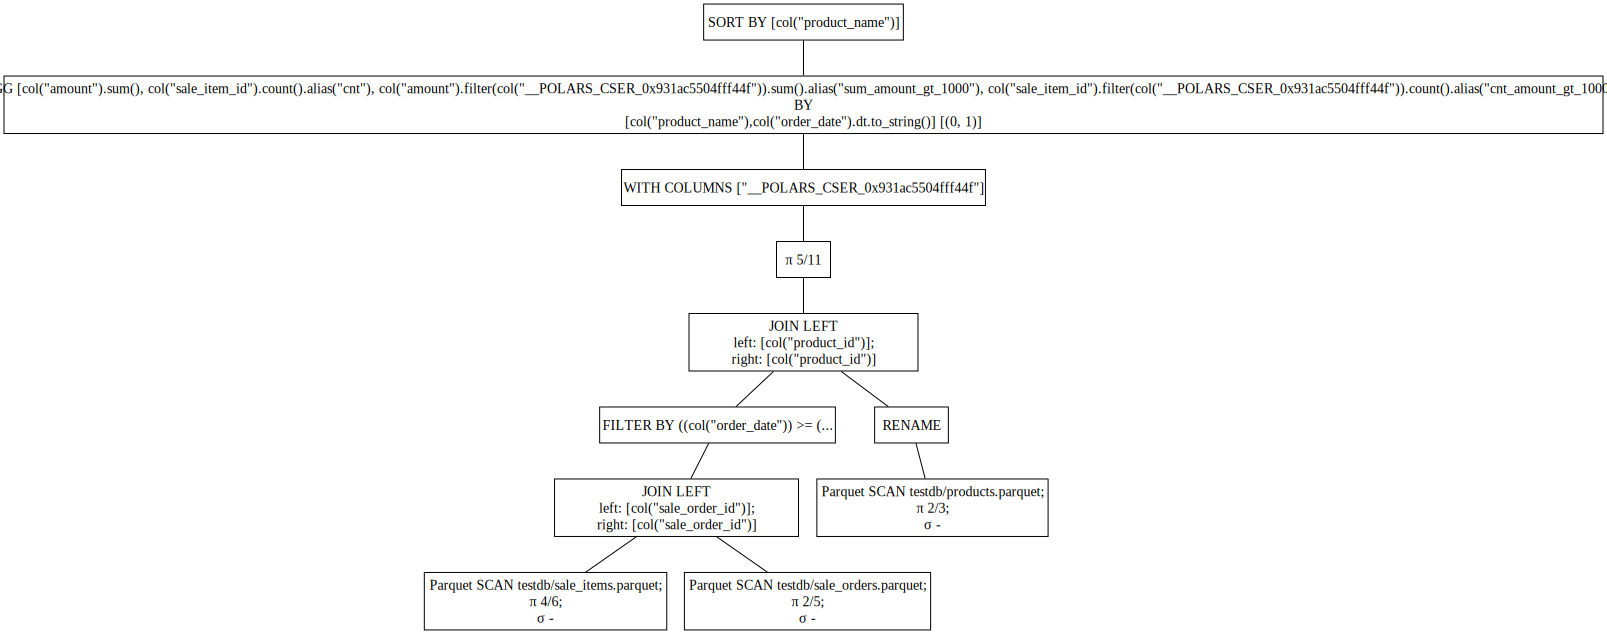

In [51]:
from datetime import date

wt2 = ((sale_items.join(sale_orders, left_on="sale_order_id", right_on="sale_order_id", how="left")
       .join(products, on ="product_id", how="left")
       ) 
       .filter( (pl.col("order_date") >= date(2022, 4, 1)) & (pl.col("order_date") < date(2022, 5, 1)) )
       .group_by( pl.col("product_name"), pl.col("order_date").dt.to_string("%Y-%m") )
       .agg( 
              pl.sum("amount"), 
              pl.count("sale_item_id").alias("cnt"),
              pl.col("amount").filter( pl.col("amount") >= 335).sum().alias("sum_amount_gt_1000"),
              pl.col("sale_item_id").filter( pl.col("amount") >= 335).count().alias("cnt_amount_gt_1000"),
       )
       .sort("product_name")
)
wt2.show_graph( optimized = True )

In [48]:
((sale_items.join(sale_orders, left_on="sale_order_id", right_on="sale_order_id", how="left")
       .join(products, on ="product_id", how="left")
       ).filter( (pl.col("product_name") == "prd_00KCOA2") & (pl.col("order_date").dt.to_string("%Y-%m") == "2022-04") )
       .filter(pl.col("amount") > 300)
       .sort("amount")
 .collect())

sale_item_id,sale_order_id,product_id,quantity,price,amount,order_date,customer_id,shop_id,freight,product_name,color
i64,i32,i32,i32,f64,f64,date,i32,i32,f64,str,str
156582366,15658236,1757,5,67.0,335.0,2022-04-01,541975,54,90.0,"""prd_00KCOA2""","""light"""
36840820,3684082,1757,5,67.0,335.0,2022-04-14,666843,56,40.0,"""prd_00KCOA2""","""light"""
96931164,9693116,1757,5,67.0,335.0,2022-04-20,437563,21,70.0,"""prd_00KCOA2""","""light"""
57355064,5735506,1757,5,67.0,335.0,2022-04-12,45615,68,90.0,"""prd_00KCOA2""","""light"""
37483115,3748311,1757,5,67.0,335.0,2022-04-02,998425,3,10.0,"""prd_00KCOA2""","""light"""
…,…,…,…,…,…,…,…,…,…,…,…
198727460,19872746,1757,5,67.0,335.0,2022-04-15,783582,77,90.0,"""prd_00KCOA2""","""light"""
156186396,15618639,1757,5,67.0,335.0,2022-04-23,110057,49,10.0,"""prd_00KCOA2""","""light"""
199087158,19908715,1757,5,67.0,335.0,2022-04-06,819658,0,30.0,"""prd_00KCOA2""","""light"""
